In [1]:
//Dependency stuff
@file:Repository("https://repo1.maven.org/maven2")
@file:DependsOn("com.github.holgerbrandl:krangl:0.18")
@file:DependsOn("com.github.holgerbrandl:kravis:0.8.5")
@file:DependsOn("thu.mohr.jonas:PhysicsExperimentLib:2.2.0")
@file:DependsOn("org.apache.commons:commons-lang3:3.12.0")

In [2]:
//Import custom library
import thu.mohr.jonas.physics.*

In [60]:
//Read raw Phyphox data
val rawData = DataFrame.readCSV("RawData.csv")

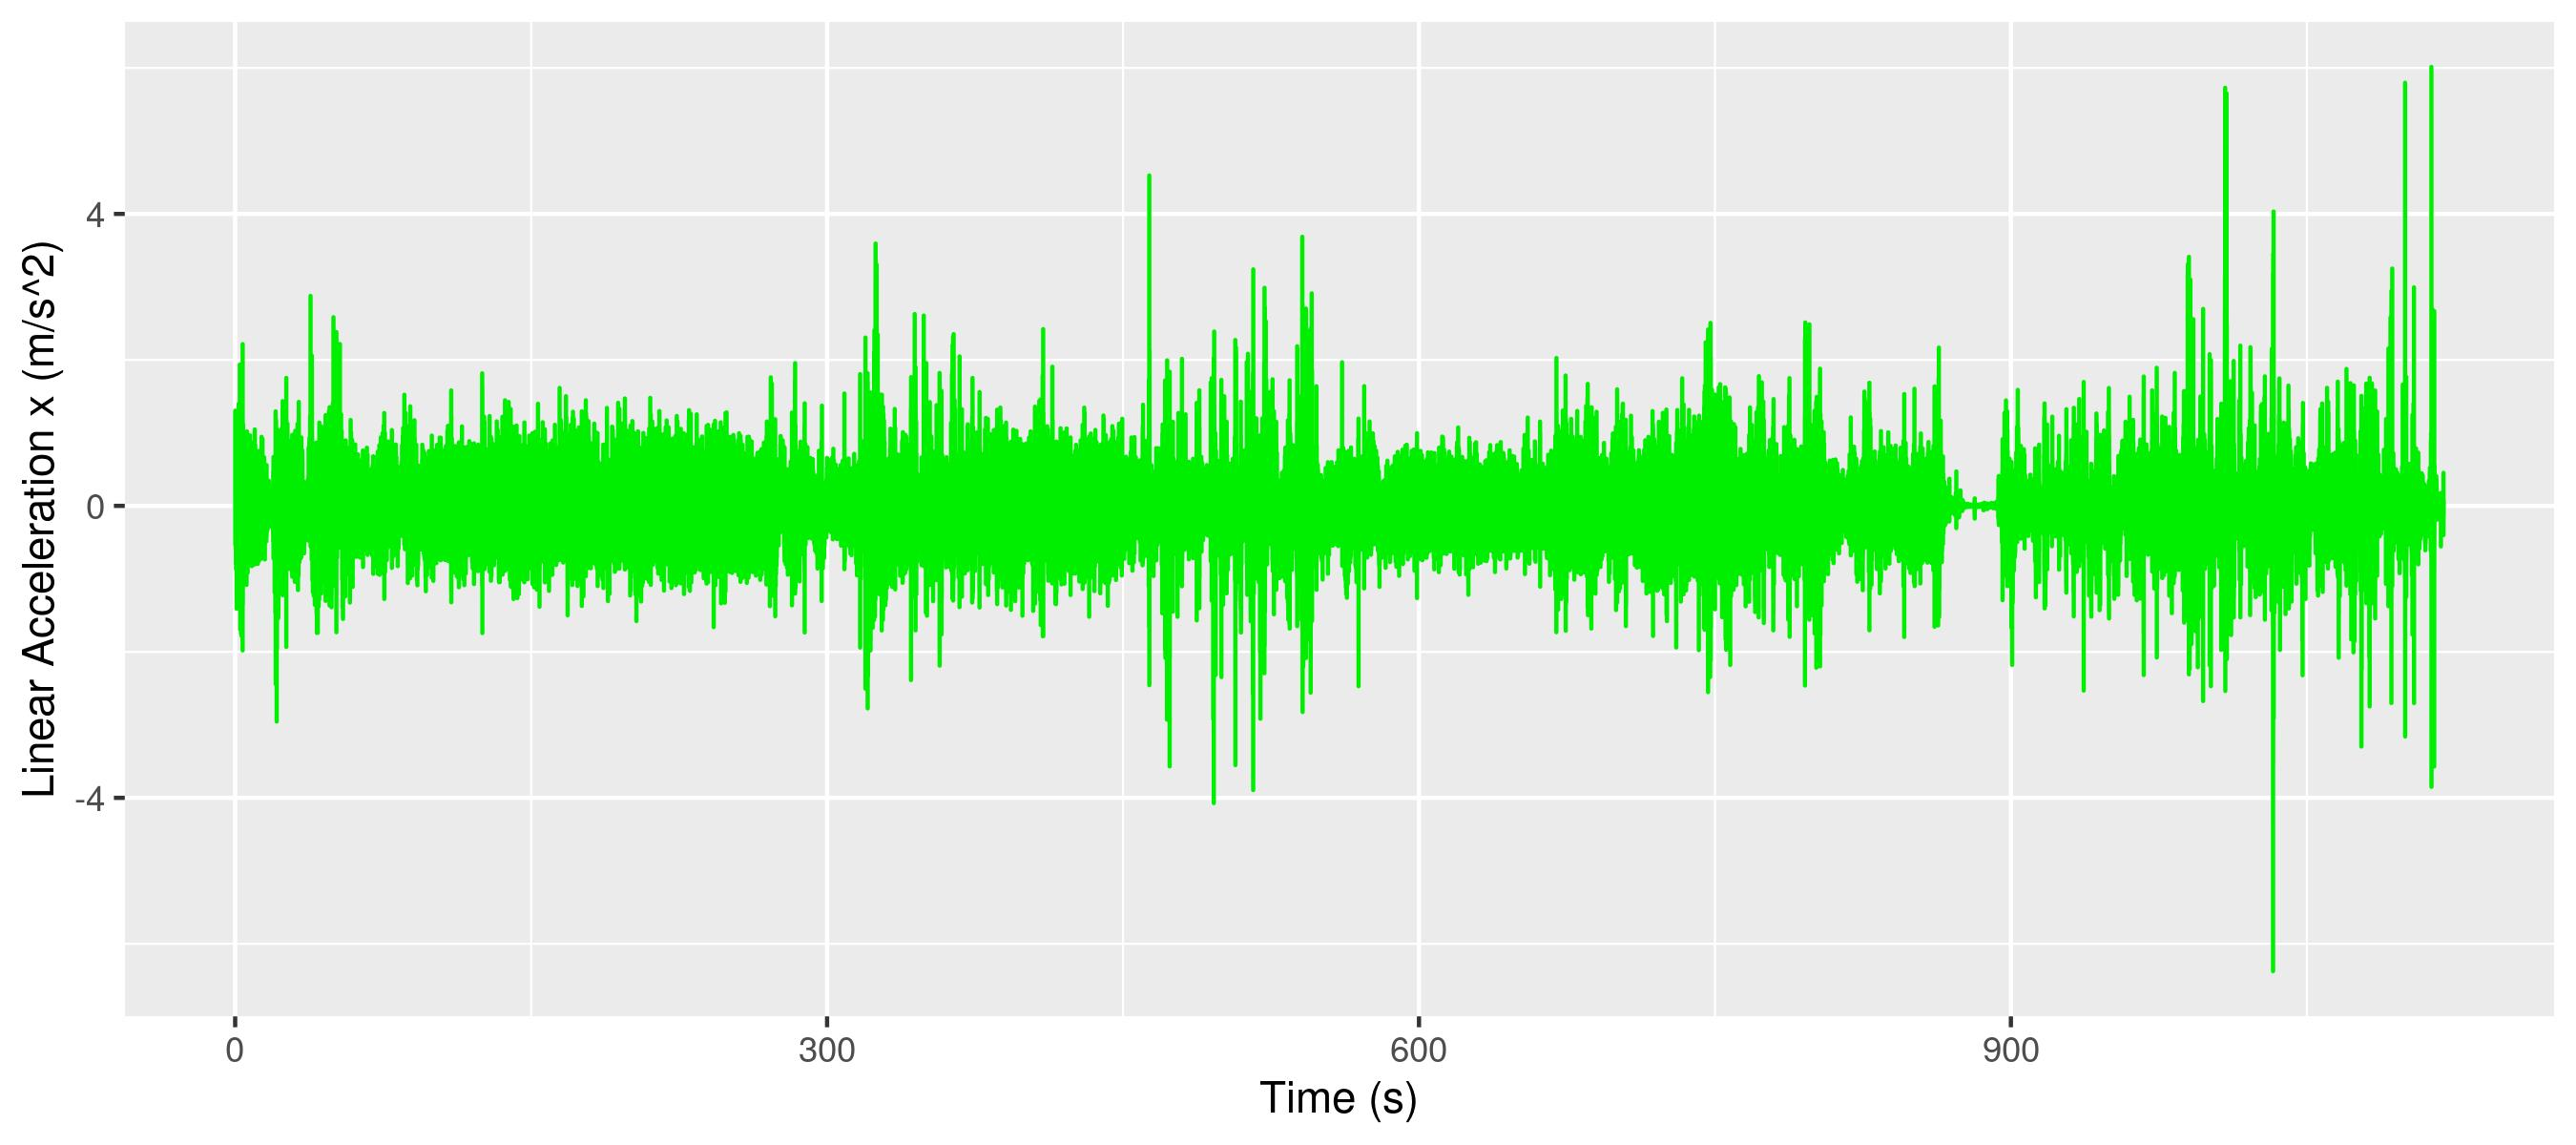

In [64]:
//Plot raw x-axis data
rawData.plot(Aes(x = "Time (s)")).geomLine(color = RColor.green2, mapping = Aes(y="Linear Acceleration x (m/s^2)"))

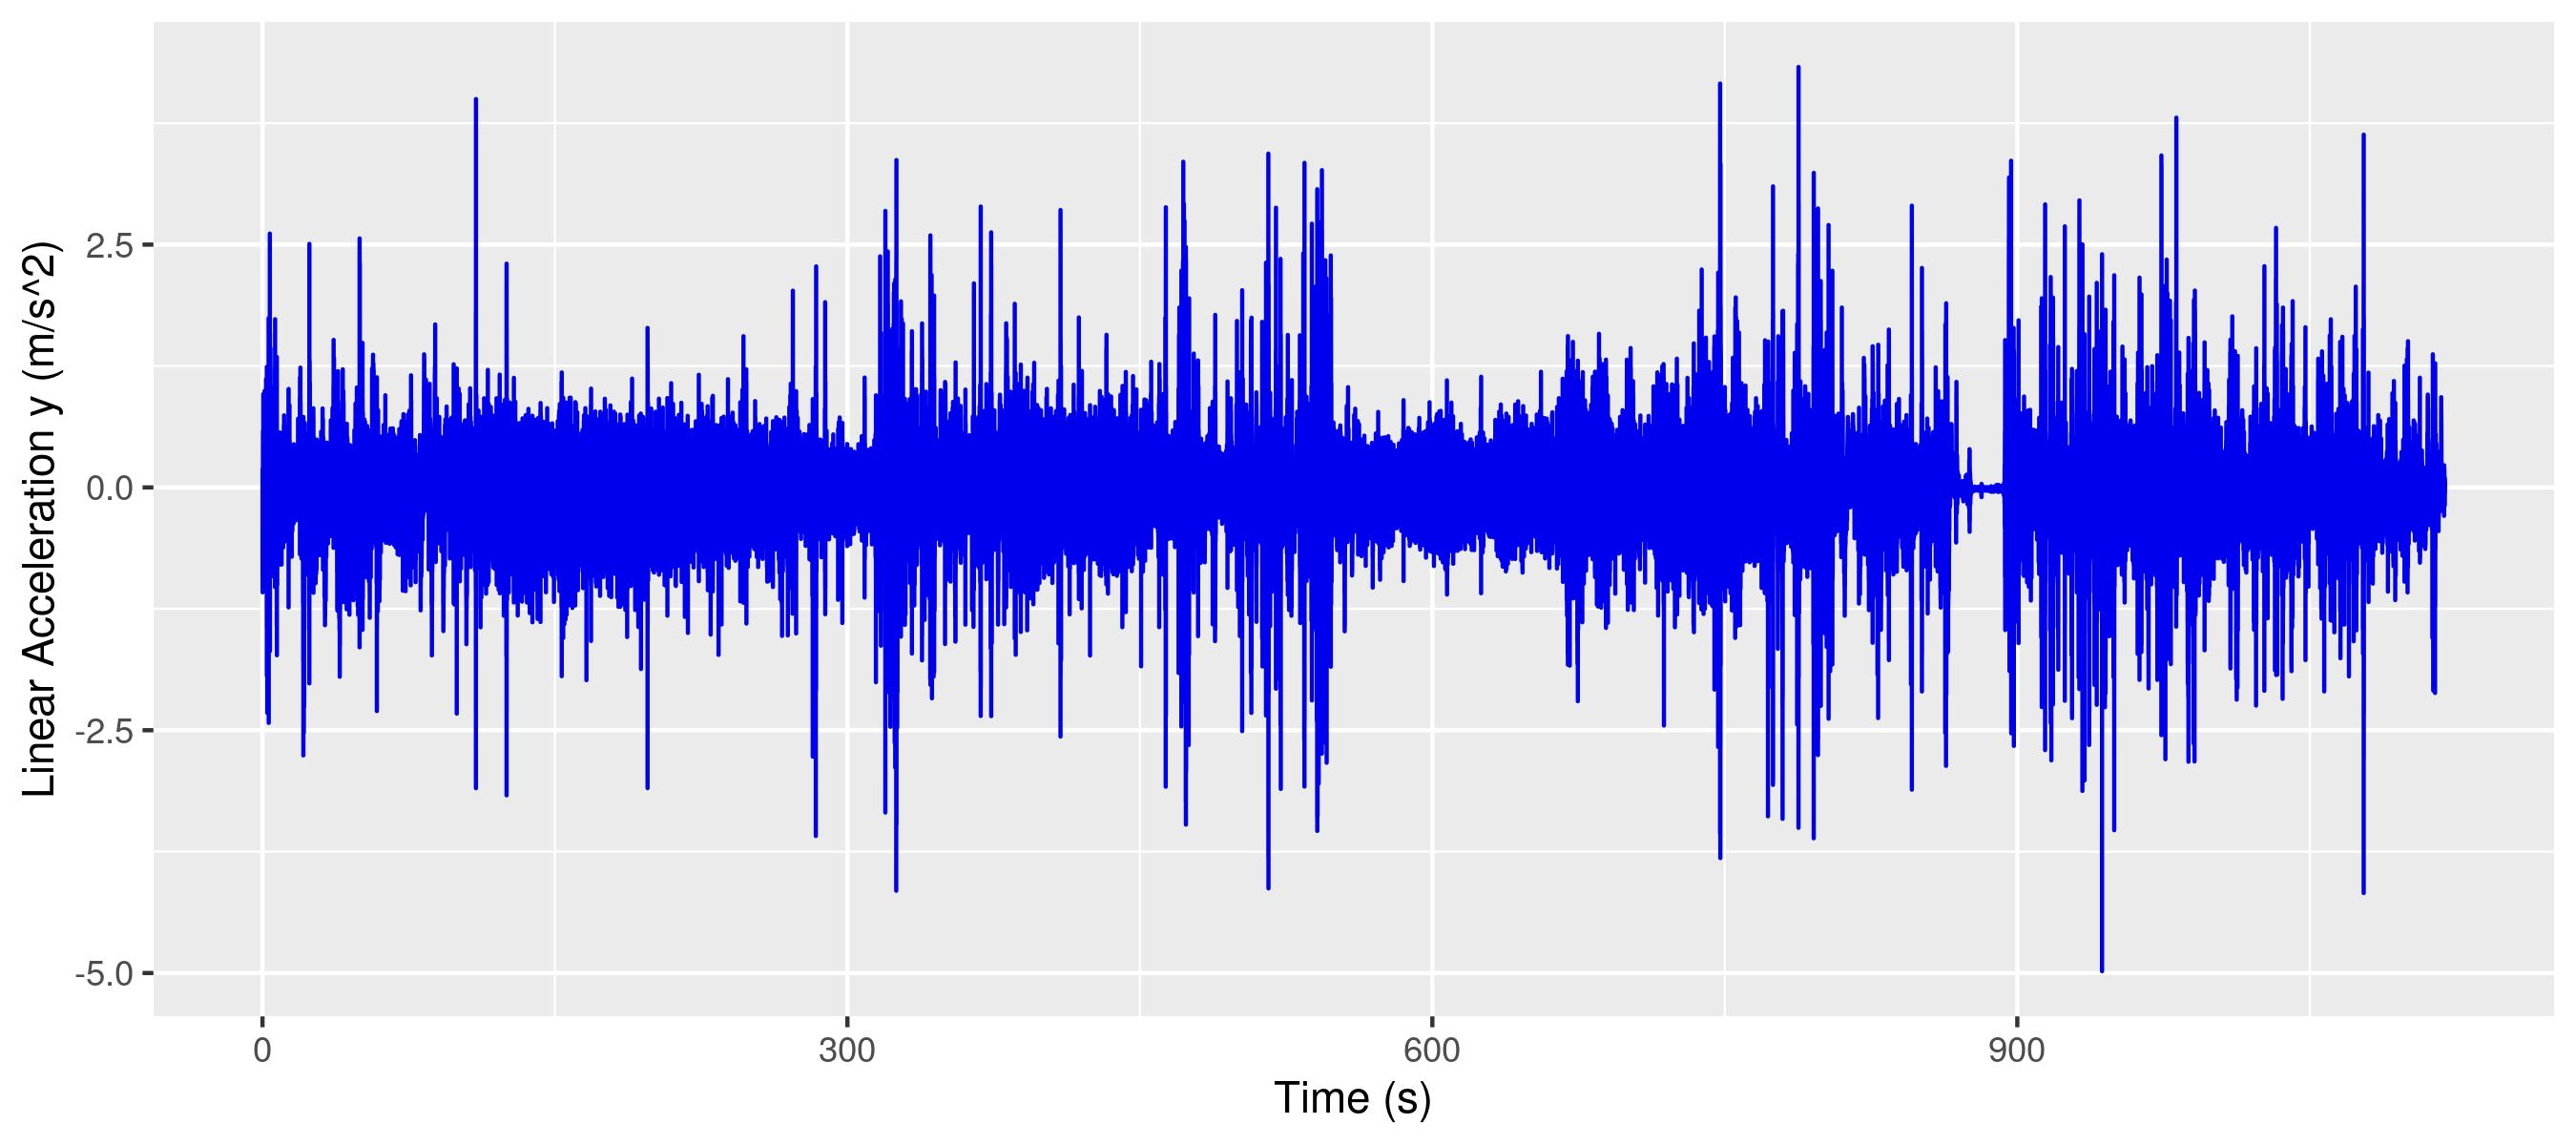

In [65]:
//Plot raw y-axis data
rawData.plot(Aes(x = "Time (s)")).geomLine(color = RColor.blue2, mapping = Aes(y="Linear Acceleration y (m/s^2)"))

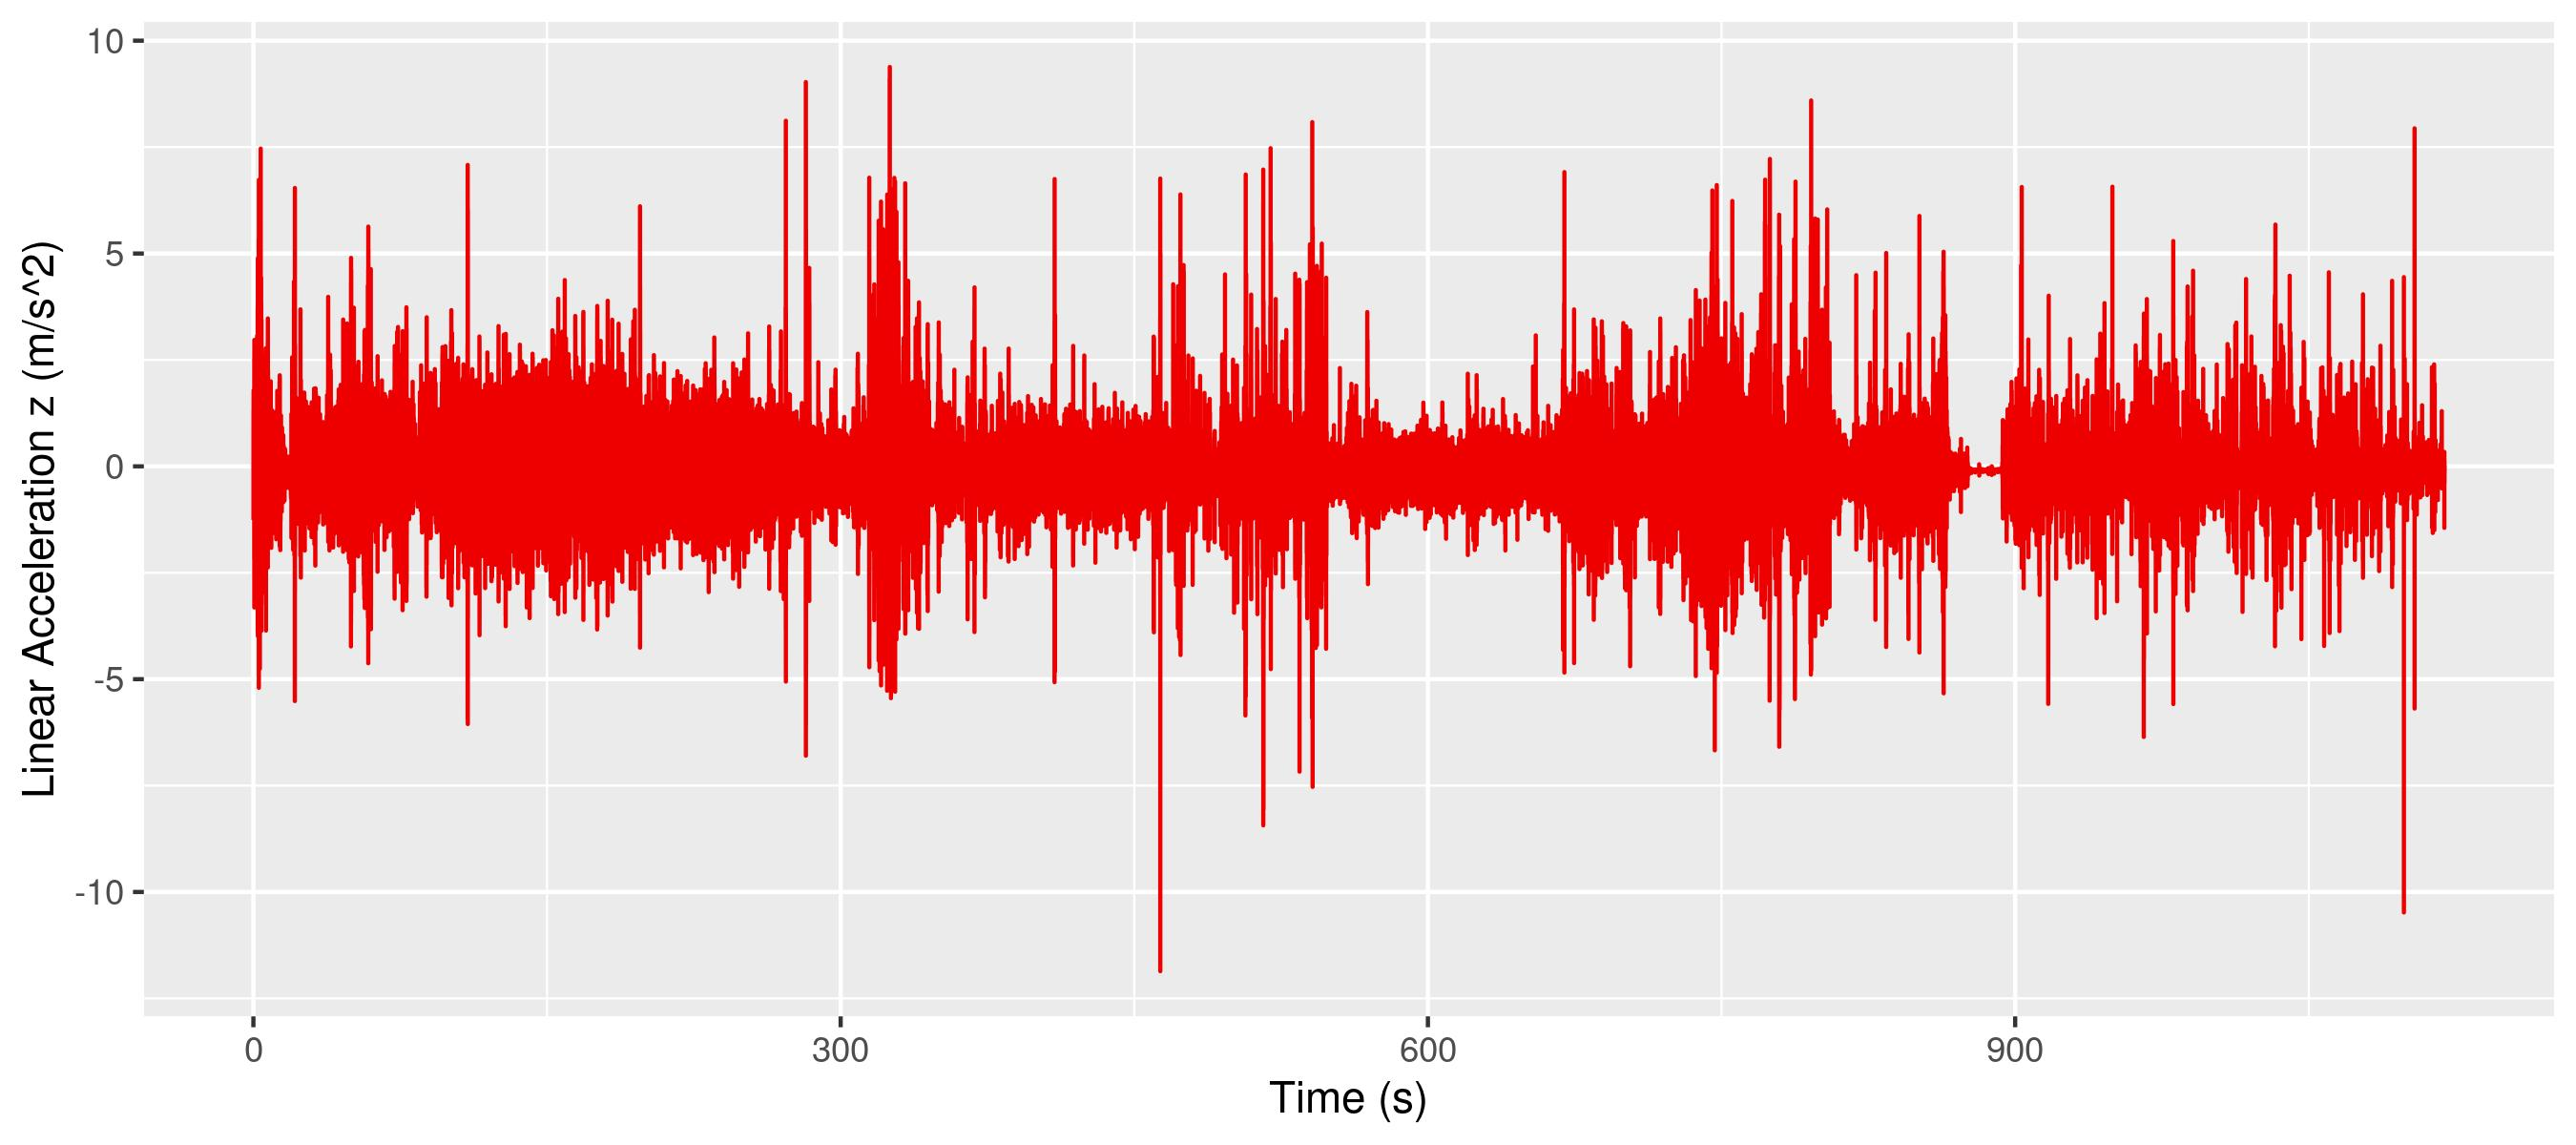

In [66]:
//Plot raw z-axis data
//In this experiment, the z-axis data is quite useless
rawData.plot(Aes(x = "Time (s)")).geomLine(color = RColor.red2, mapping = Aes(y="Linear Acceleration z (m/s^2)"))

In [23]:
//Map chunks of size 2 to ValueRelations
val valueRelations = rawData.rows.chunked(2)
    //An uneven amount of data-points causes one half-empty chunk, filtering it out
    .filter{chunk -> chunk.size == 2}
    .map { valueChunk -> ValueRelation(valueChunk[0]["Linear Acceleration y (m/s^2)"] as Double, 
                                       valueChunk[1]["Linear Acceleration y (m/s^2)"] as Double,
                                       valueChunk[0]["Time (s)"] as Double, 
                                       valueChunk[1]["Time (s)"] as Double
    )}

In [32]:
//A simple test pattern to find in the data: 2 to ∞ adjacent data-points with a rise of 1.0 to ∞ g's each
val testPattern = ValuePattern(ValuePatternPart(ValueRelationType.ASCENDING, 2, Int.MAX_VALUE, 1.0, Double.MAX_VALUE))

In [62]:
//Filter the rows according to our previously defined pattern
import org.apache.commons.lang3.builder.ReflectionToStringBuilder
import org.apache.commons.lang3.StringUtils
val filteredRelations = valueRelations.chunked(3).filter{chunk -> testPattern.matches(chunk)}

In [46]:
//Flatten the chunks of rows and map them to their time of occurence
val mappedTimes = filteredRelations.flatten().map{relation -> relation.firstValueTime!!}

In [61]:
//Get only the rows from the raw data we previously filtered out
val filteredData = rawData.filterByRow { mappedTimes.contains(it["Time (s)"] as Double) }

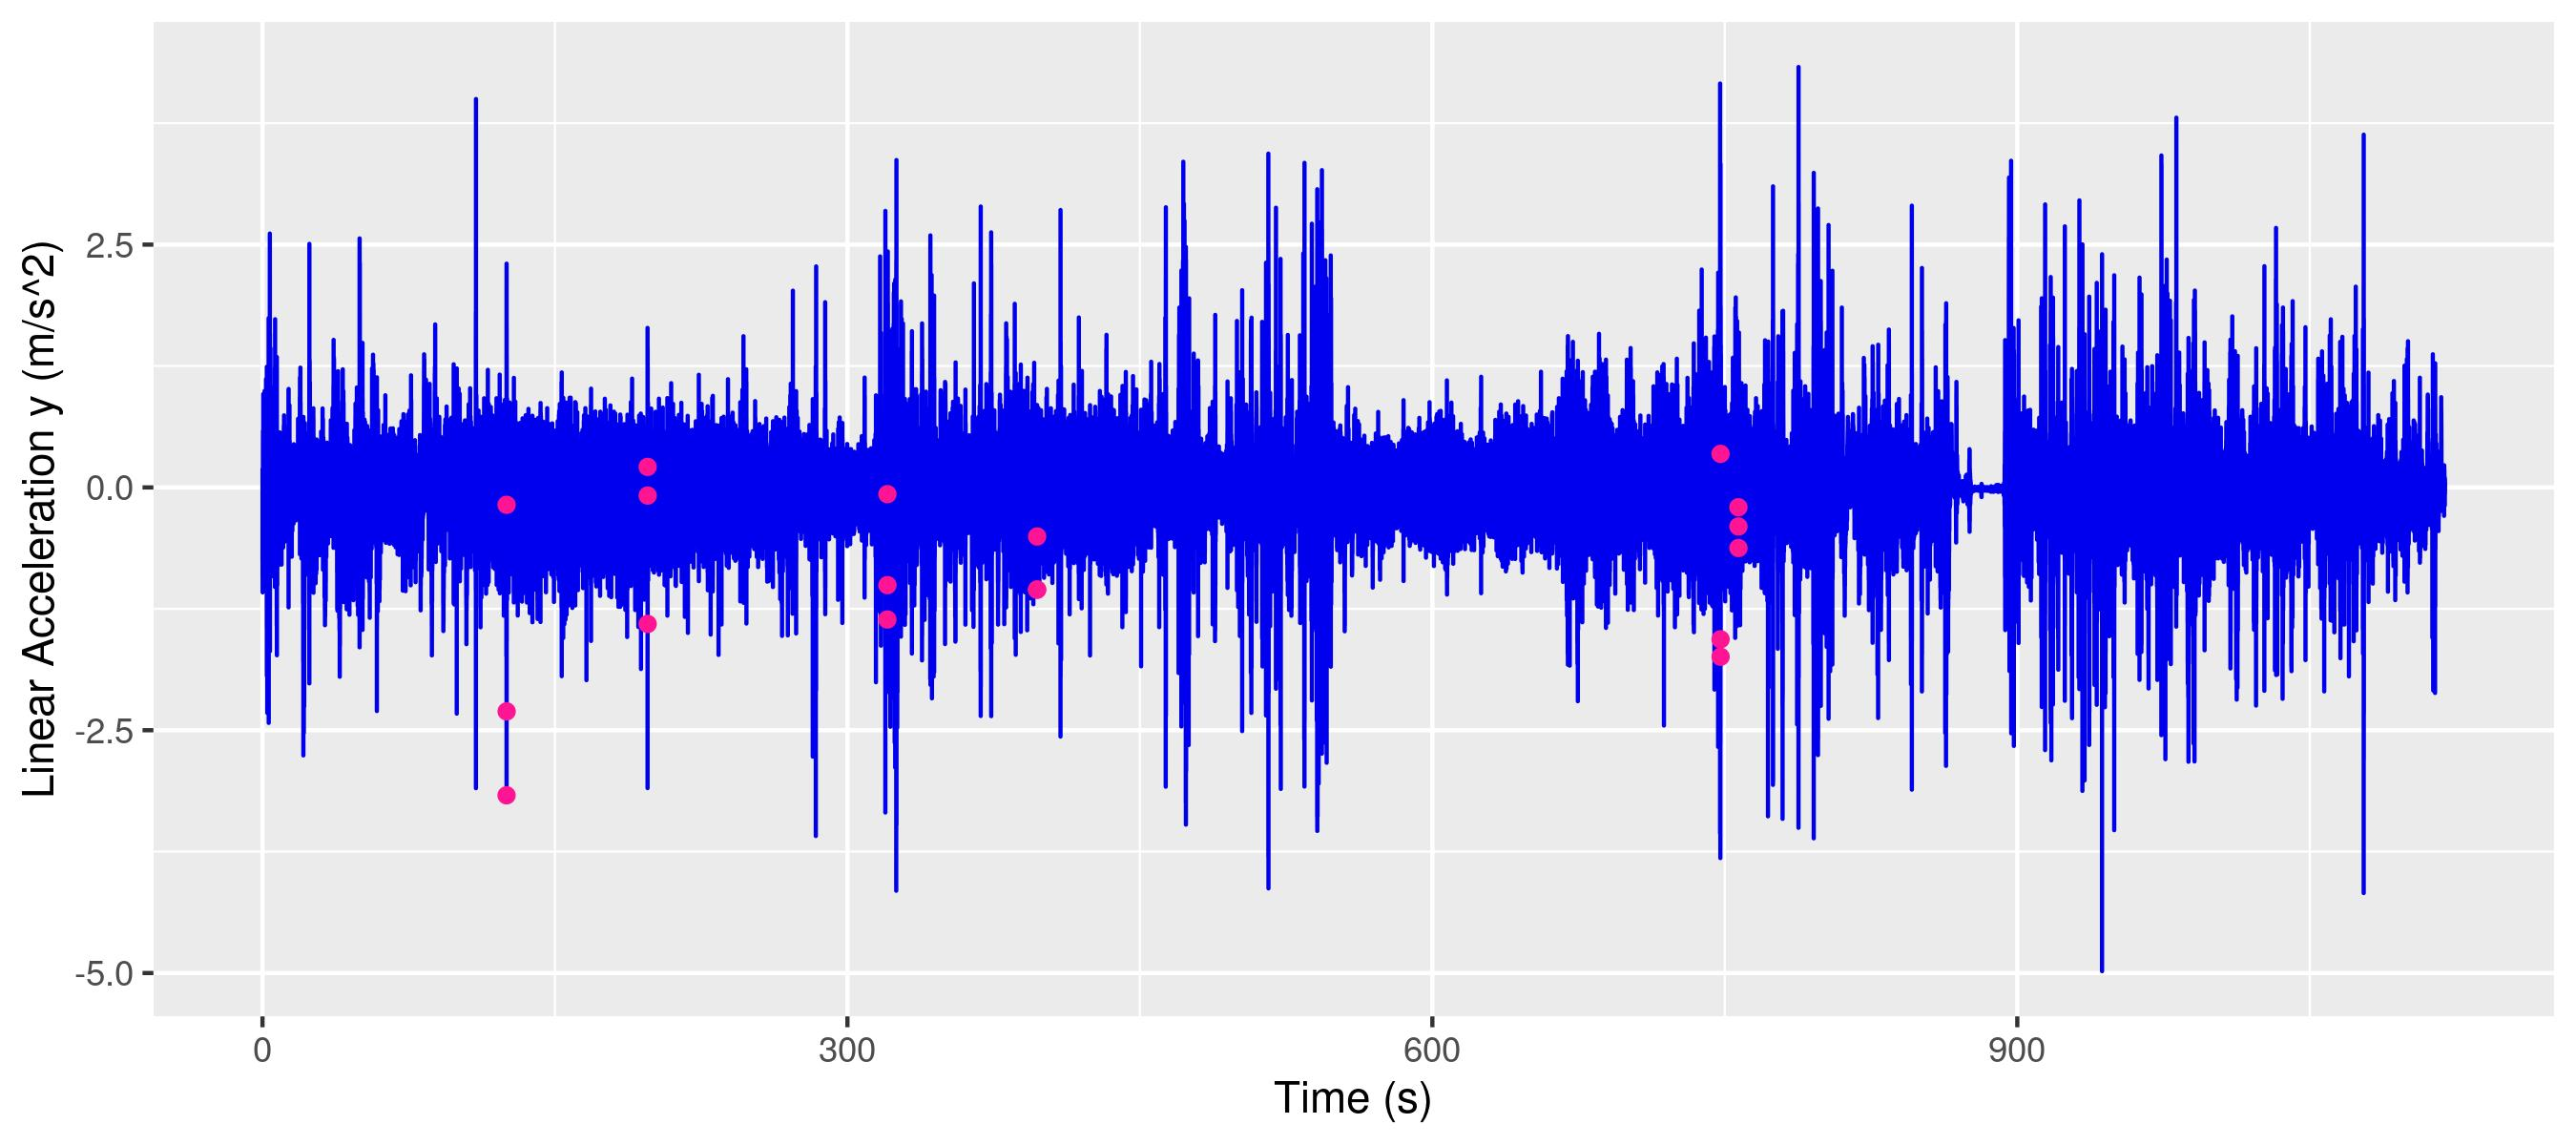

In [59]:
//Plot the raw data as well as the filtered data
rawData.plot(Aes(x = "Time (s)"))
    .geomLine(color = RColor.blue2, mapping = Aes(y="Linear Acceleration y (m/s^2)"))
    .geomPoint(color = RColor.deeppink, mapping = Aes(y="Linear Acceleration y (m/s^2)"), `data` = filteredData)